In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os

2024-03-06 17:47:28.684190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 17:47:28.684231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 17:47:28.684890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 17:47:28.688817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 17:47:29.102764: W tensorflow/compiler/tf2

In [22]:
# Eingabe- und Ausgabeordner definieren
input_folder = './ASL_unique/'
output_folder = './sorted_VGG16opti'

# Daten in Trainings- und Validierungsordner aufteilen
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2), group_prefix=None)

# Zielgröße der Bilder definieren
target_size = (224, 224)

# Datenagumentierung für Trainings- und Validierungsdaten erstellen
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Daten-Generatoren für Trainings- und Validierungsdaten erstellen
train_generator = train_datagen.flow_from_directory(
    output_folder + '/train',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    output_folder + '/val',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

Copying files: 39956 files [00:01, 30823.30 files/s]


Found 31962 images belonging to 8 classes.
Found 7994 images belonging to 8 classes.


In [23]:
# Eingabeordner definieren
input_folder = './ASL_test'

# Daten-Generatoren für Testdaten erstellen
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    input_folder,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7200 images belonging to 8 classes.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 3, 512)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 2056      
                                                      

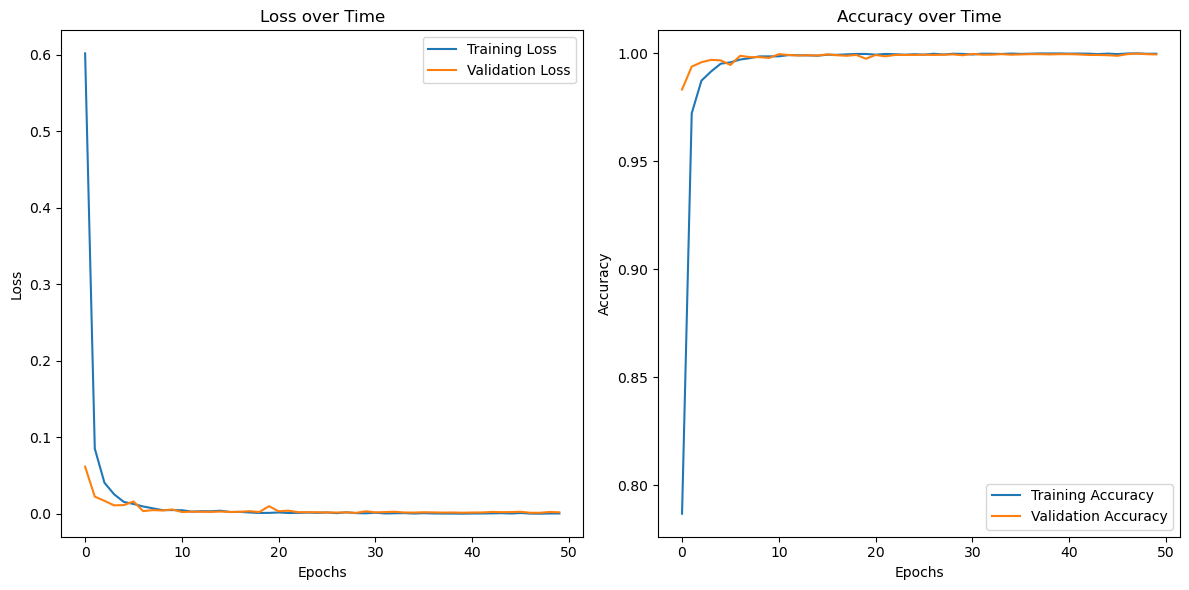

225/225 [==============================] - 37s 163ms/step - loss: 2.5808 - accuracy: 0.6950
Test Loss: 2.5808
Test Accuracy: 69.50%


In [24]:
# Schritt 1: Laden des vortrainierten VGG16-Modells
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Schritt 2: Definieren des Modells und Hinzufügen eines benutzerdefinierten Klassifikators zum VGG16-Modell
model = models.Sequential()
model.add(vgg_model)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))  # Anzahl der Klassen entsprechend anpassen

# Schritt 3: Kompilieren des Modells
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Schritt 4: Trainieren des Modells mit den Trainings- und Validierungsdaten
history = model.fit(train_generator, epochs=25, validation_data=val_generator)

# Schritt 5: Auswertung des Modells auf dem Testdatensatz
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Schritt 6: Visualisierung der Trainings- und Validierungsverluste und -genauigkeiten über die Zeit
plt.figure(figsize=(12, 6))

# Plot Loss über die Zeit
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Verlust über die Zeit')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()

# Plot Accuracy über die Zeit
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Genauigkeit über die Zeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Zielverzeichnis zum Speichern der Bilder definieren
save_directory = './Result'
os.makedirs(save_directory, exist_ok=True)

# Iteration über die Testdaten
for _ in range(1):
    # Vorhersagen des Modells für die Testdaten
    predictions = model.predict(test_generator)
    true_labels = test_generator.classes 
    
    # Indizes der inkorrekten Vorhersagen finden
    incorrect_indices = np.where(np.argmax(predictions, axis=1) != true_labels)[0]

    # Anzahl der anzuzeigenden Beispiele definieren
    num_samples_to_display = 5
    for i in range(min(num_samples_to_display, len(incorrect_indices))):
        # Index des Batches und Index innerhalb des Batches
        batch_index = incorrect_indices[i] // test_generator.batch_size
        in_batch_index = incorrect_indices[i] % test_generator.batch_size

        # Bild und zugehörige Labels extrahieren
        image = test_generator[batch_index][0][in_batch_index]
        true_label = true_labels[incorrect_indices[i]]
        predicted_label = np.argmax(predictions[incorrect_indices[i]])

        # Bild anzeigen
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f'Wahres Label: {true_label}, Vorhergesagtes Label: {predicted_label}')

        # Bild speichern
        image_filename = f'falsches_bild_{i+1}_wahr_{true_label}_vorhergesagt_{predicted_label}.png'
        image_path = os.path.join(save_directory, image_filename)
        plt.savefig(image_path)

        # Plot schließen, um nicht angezeigt zu werden
        plt.close()

225/225 [==============================] - 36s 158ms/step


In [26]:
print("Class indices in test_generator:", test_generator.class_indices)

Class indices in test_generator: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}
